In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from statsmodels.stats.multitest import multipletests

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Prep data

In [2]:
ls /Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/

GTEx_Analysis_v8_eQTL_covariates/     GTEx_meta_forJake.csv
GTEx_Analysis_v8_eQTL_covariates.zip  Human_GXp_matrix.csv
GTEx_brain_norm_noregress.csv         Mouse_GXp_matrix.csv
GTEx_brain_norm_noregress_meta.csv    PLS_Component_Expr.csv
GTEx_expr_forJake.csv                 genes_forJake.csv


In [3]:
df = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress_meta.csv')

In [4]:
bwdf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_meta_forJake.csv')
bwcols = ['AGE','brainweight', 'weight','height', 'race', 'ethnicity']
df.loc[:,'merger'] = ['%s_%s'%(df.loc[x,'SUBJID'],
                               df.loc[x,'SMTSD']) for x in df.index]
bwdf.loc[:,'merger'] = ['%s_%s'%(bwdf.loc[x,'SUBJID'],
                               bwdf.loc[x,'SMTSD']) for x in bwdf.index]
jnk = pandas.DataFrame(df,copy=True)
jnk.loc[:,'old_ind'] = jnk.index.values
jnk.index = jnk.merger.values
bwdf.index = bwdf.merger.values
shared = list(set(bwdf.index) & set(jnk.index))
for col in bwcols:
    jnk.loc[shared,col] = bwdf.loc[shared,col].values
    df.loc[:,col] = jnk.loc[:,col].values

In [5]:
len(df.SUBJID.unique())

376

In [6]:
df.SMTSD.unique()

array(['Brain - Cortex', 'Brain - Cerebellum',
       'Brain - Frontal Cortex (BA9)', 'Brain - Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Hypothalamus',
       'Brain - Hippocampus', 'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Cerebellar Hemisphere', 'Brain - Substantia nigra',
       'Brain - Amygdala'], dtype=object)

In [7]:
df.SMTSD.value_counts()

Brain - Cortex                               255
Brain - Nucleus accumbens (basal ganglia)    246
Brain - Caudate (basal ganglia)              246
Brain - Cerebellum                           241
Brain - Cerebellar Hemisphere                215
Brain - Frontal Cortex (BA9)                 209
Brain - Putamen (basal ganglia)              205
Brain - Hypothalamus                         202
Brain - Hippocampus                          197
Brain - Anterior cingulate cortex (BA24)     176
Brain - Amygdala                             152
Brain - Substantia nigra                     139
Name: SMTSD, dtype: int64

In [8]:
exp = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress.csv')

In [9]:
exp.shape

(15758, 2484)

In [10]:
exp.columns = ['ENSGID'] + exp.columns[1:].tolist()

In [11]:
genes = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/genes_forJake.csv')
genes

,hgnc_symbol,ensembl_gene_id,chromosome_name,start_position,end_position,entrezgene_id
0,FGR,ENSG00000000938,1,27612064,27635185,2268.0
1,STPG1,ENSG00000001460,1,24356999,24416934,90529.0
2,NIPAL3,ENSG00000001461,1,24415802,24472976,57185.0
3,AK2,ENSG00000004455,1,33007940,33080996,204.0
4,KDM1A,ENSG00000004487,1,23019443,23083689,23028.0
...,...,...,...,...,...,...
15738,NaN,ENSG00000280216,22,39379610,39380015,NaN
15739,NaN,ENSG00000281538,22,42138060,42139726,NaN
15740,NaN,ENSG00000283366,22,19014353,19014506,NaN
15741,NaN,ENSG00000283438,22,23132730,23133005,NaN


# Whole dataset congruence

In [12]:
gdict = dict(zip(genes.ensembl_gene_id.values,
                genes.hgnc_symbol.values))
gmatch = [np.nan if x not in gdict.keys() else \
          gdict[x] for x in exp.ENSGID.values]

In [13]:
exp.loc[:,'gene_symbol'] = gmatch
exp.dropna(inplace=True)

In [14]:
comps = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv')
comps.head()

,gene_symbol,gene_name,C1_expr,C2_expr,C3_expr
0,A1BG,alpha-1-B glycoprotein,0.001517,0.006065,-0.020001
1,A1BG-AS1,NaN,-0.006685,-0.006733,-0.002762
2,A2M,alpha-2-macroglobulin,0.005135,0.007225,0.002345
3,A2ML1,alpha-2-macroglobulin-like 1,-0.009261,-0.004295,-0.010945
4,A3GALT2,NaN,-0.001305,-0.000388,-0.000463


In [15]:
# # match on entrez id
# probes = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/Probes.csv')
# shared_ids = list(set(probes.entrez_id) & set(genes.entrezgene_id))
# matched_genes = pandas.DataFrame(genes[genes.entrezgene_id.isin(shared_ids)],
#                                 copy=True)
# # matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
# #                                  copy=True)


In [16]:
# changer = {}

# assessdf = matched_genes[['hgnc_symbol','entrezgene_id']]
# for i,row in assessdf.iterrows():
#     gsym = row['hgnc_symbol']
#     eid = row['entrezgene_id']
#     asym = probes.loc[probes.entrez_id==eid,'gene_symbol'].values[0]
#     if asym != gsym:
#         print(i,'GTex: %s, Allen: %s '%(gsym,asym),eid)
#         changer.update({i: asym})
#     #else
#     #print(i,'GTex: %s, Allen: %s '%(gsym,asym),eid)

In [17]:
# for i, sym in changer.items():
#     matched_genes.loc[i,'hgnc_symbol'] = sym

In [18]:
# #address duplicates in GTex
# n_counts = matched_genes.hgnc_symbol.value_counts()
# dups = n_counts[n_counts==2].index
# dupdf = matched_genes[matched_genes.hgnc_symbol.isin(dups)]

In [19]:
# done = []
# avg = {}
# count = 0
# jnk = dupdf[['hgnc_symbol','entrezgene_id']
#                   ].sort_values('hgnc_symbol')
# for i,row in jnk.iterrows():
#     sym = row['hgnc_symbol']
#     if sym in done:
#         count += 1
#         continue
#     else:
#         eid1 = row['entrezgene_id']
#         eid2 = jnk.loc[jnk.index[(count+1)],'entrezgene_id']
#         if eid1 == eid2:
#             avg.update({sym:[i,jnk.index[(count+1)]]})
#         else:
#             asym1 = probes.loc[probes.entrez_id==eid1,'gene_symbol'].values[0]
#             asym2 = probes.loc[probes.entrez_id==eid2,'gene_symbol'].values[0]
#             print('GTex: %s, Allen: %s or %s'%(sym,asym1,asym2))
#             avg.update({sym:[i,jnk.index[(count+1)]]})
#         done.append(sym)
#         count += 1

In [20]:
# sns.regplot(exp.loc[5834].values,exp.loc[5457].values)

These appear to be true duplicates, and yet the gene expression is only slightly correlated. I'm going to only keep the one with the higher coefficient of variation

In [21]:
# for nm, ids in avg.items():
#     cv = exp.loc[ids].std(1) / exp.loc[ids].mean(1)
#     loser = cv.sort_values().index[0]
#     matched_genes.drop(loser,axis=0,inplace=True)

#### Match genes

In [15]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
len(shared_genes)

12647

In [16]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
                                 copy=True)
exp = pandas.DataFrame(exp[exp.gene_symbol.isin(shared_genes)],
                                copy=True)

In [17]:
egenes = exp.gene_symbol.values

In [18]:
exp.shape

(12647, 2485)

In [19]:
matched_comps.shape

(12647, 5)

In [136]:
# shared_genes = list(set(comps.gene_symbol) & set(matched_genes.hgnc_symbol))
# matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
#                                  copy=True)
# rematched_genes = pandas.DataFrame(matched_genes[matched_genes.hgnc_symbol.isin(shared_genes)],
#                                 copy=True)

In [142]:
# exp = exp.loc[rematched_genes.index]

#### regress covariates

In [26]:
import statsmodels.formula.api as smf

In [213]:
df.columns[7:12]

Index(['SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'], dtype='object')

In [216]:
row.values.shape

(2391,)

In [218]:
nexp.shape

(11179, 2391)

In [33]:
dat.shape

(2483, 6)

In [34]:
exp.shape

(12647, 2485)

In [49]:
nexp = np.zeros_like(exp.iloc[:,1:-1].values)
dat = pandas.DataFrame(df[df.columns[8:13]],copy=True)
count = 0
for i,row in exp.iterrows():
    dat.loc[:,'exp'] = row.values[1:-1].astype(float)
    mod = smf.ols('exp ~ SeqPC1 + SeqPC2 + SeqPC3 + SeqPC4 + SeqPC5',
                  data=dat).fit()
    nexp[count,:] = mod.resid.values
    if count%100==0:
        print('finished %s of %s'%(count+1,len(nexp)))
    count+=1

finished 1 of 12647
finished 101 of 12647
finished 201 of 12647
finished 301 of 12647
finished 401 of 12647
finished 501 of 12647
finished 601 of 12647
finished 701 of 12647
finished 801 of 12647
finished 901 of 12647
finished 1001 of 12647
finished 1101 of 12647
finished 1201 of 12647
finished 1301 of 12647
finished 1401 of 12647
finished 1501 of 12647
finished 1601 of 12647
finished 1701 of 12647
finished 1801 of 12647
finished 1901 of 12647
finished 2001 of 12647
finished 2101 of 12647
finished 2201 of 12647
finished 2301 of 12647
finished 2401 of 12647
finished 2501 of 12647
finished 2601 of 12647
finished 2701 of 12647
finished 2801 of 12647
finished 2901 of 12647
finished 3001 of 12647
finished 3101 of 12647
finished 3201 of 12647
finished 3301 of 12647
finished 3401 of 12647
finished 3501 of 12647
finished 3601 of 12647
finished 3701 of 12647
finished 3801 of 12647
finished 3901 of 12647
finished 4001 of 12647
finished 4101 of 12647
finished 4201 of 12647
finished 4301 of 12647


In [59]:
exp = pandas.DataFrame(nexp,index=exp.index,columns=exp.columns[1:-1])

#### get expression of each component for each GTex sample

In [156]:
# sorter = rematched_genes.sort_values('hgnc_symbol').index
# exp = exp.loc[sorter]

In [60]:
exp.loc[:,'gene_symbol'] = egenes

In [61]:
exp.sort_values('gene_symbol',inplace=True)

In [ ]:
# exp = pandas.read_csv(...)

In [62]:
all(matched_comps.gene_symbol.values == exp.gene_symbol.values)

True

In [65]:
exp.to_csv('/Users/jacobv/Science/PLS_GXP/GTex_harmed_GExp.csv')

# Analyses

In [20]:
exp = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTex_harmed_GExp.csv',
                     index_col=0)

In [21]:
scols = exp.columns[:-1]
pred = pandas.DataFrame()
for i in range(1,4):
    pred.loc[:,'C%s'%i] = np.dot(exp[scols].values.T,
                                 matched_comps['C%s_expr'%i])
pred.loc[:,'sample'] = scols
pred.loc[:,'Region'] = df.loc[:,'SMTSD'].values

In [21]:
scols

Index(['GTEX-1117F-3226-SM-5N9CT', 'GTEX-111FC-3126-SM-5GZZ2',
       'GTEX-111FC-3326-SM-5GZYV', 'GTEX-1128S-2726-SM-5H12C',
       'GTEX-1128S-2826-SM-5N9DI', 'GTEX-117XS-3026-SM-5N9CA',
       'GTEX-117XS-3126-SM-5GIDP', 'GTEX-1192X-0011-R10a-SM-DO941',
       'GTEX-1192X-0011-R5a-SM-DNZZA', 'GTEX-1192X-0011-R6a-SM-DNZZB',
       ...
       'GTEX-ZXG5-0011-R5b-SM-57WBN', 'GTEX-ZXG5-0011-R6a-SM-57WBZ',
       'GTEX-ZXG5-0011-R7b-SM-57WCC', 'GTEX-ZXG5-0011-R8a-SM-57WD1',
       'GTEX-ZYFD-2926-SM-5GID9', 'GTEX-ZYFD-3026-SM-5E44C',
       'GTEX-ZYY3-3026-SM-5GIEJ', 'GTEX-ZYY3-3126-SM-5SI9L',
       'GTEX-ZZPT-2926-SM-5EQ5S', 'GTEX-ZZPT-3026-SM-5GZXH'],
      dtype='object', length=2483)

In [22]:
rkey = dict(zip(pred.Region.unique(),
               ['Frontal','Cerebellum','Frontal','Caudate','Accumbens',
               'Putamen','Hypothalamus','Hippocampus','AntCing',
               'Cerebellum','Nigra','Amygdala']))

In [288]:
pred.Region.unique()

array(['Brain - Cortex', 'Brain - Cerebellum',
       'Brain - Frontal Cortex (BA9)', 'Brain - Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Hypothalamus',
       'Brain - Hippocampus', 'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Cerebellar Hemisphere', 'Brain - Substantia nigra',
       'Brain - Amygdala'], dtype=object)

In [23]:
for i,row in pred.iterrows():
    pred.loc[i,'Div'] = rkey[row['Region']]

In [31]:
pred.head()

,C1,C2,C3,sample,Region,Div
0,-6.666732,-7.399462,-1.290747,GTEX-1117F-3226-SM-5N9CT,Brain - Cortex,Frontal
1,-7.945171,-4.575685,-2.022463,GTEX-111FC-3126-SM-5GZZ2,Brain - Cortex,Frontal
2,15.704045,-3.350887,3.526193,GTEX-111FC-3326-SM-5GZYV,Brain - Cerebellum,Cerebellum
3,-14.417177,-11.016445,-0.411719,GTEX-1128S-2726-SM-5H12C,Brain - Cortex,Frontal
4,10.318082,-8.163148,3.776098,GTEX-1128S-2826-SM-5N9DI,Brain - Cerebellum,Cerebellum


In [38]:
#gtC = pred.groupby('Div')[['C1','C2','C3']].mean().sort_index()
younger = df[df.AGE<61][df.columns[0]].values
gtC = pred[pred['sample'].isin(younger)].groupby('Div')[['C1','C2','C3']].mean().sort_index()
gtC.loc[:,'GTeX_div'] = gtC.index
gtC 

,C1,C2,C3,GTeX_div
Div,,,,
Accumbens,-7.068317,6.902542,-3.375619,Accumbens
Amygdala,-3.174481,2.696531,-5.343806,Amygdala
AntCing,-14.087233,-2.126187,-3.652315,AntCing
Caudate,-5.237221,6.340412,0.036800,Caudate
Cerebellum,15.678316,-9.948835,2.717828,Cerebellum
Frontal,-17.117965,-7.827179,-3.519505,Frontal
Hippocampus,-2.939507,-0.992961,-3.413275,Hippocampus
Hypothalamus,7.391103,11.480298,4.015693,Hypothalamus
Nigra,17.074576,10.848327,8.503490,Nigra


In [25]:
allenC1 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GCorr_GTexComp_ABA_C1_data.csv')
allenC1

,GTeX_div,Component1_Expresion,sem
0,Accumbens,-0.045505,0.028566
1,Amygdala,0.054248,0.012812
2,AntCing,-0.373338,0.011132
3,Caudate,-0.036103,0.008187
4,Cerebellum,0.361286,0.002174
5,Frontal,-0.420333,0.004016
6,Hippocampus,-0.030688,0.007216
7,Hypothalamus,0.228722,0.006926
8,Nigra,0.251120,0.010862
9,Pallidum,0.223105,0.008236


r = 0.95, p = 0.0


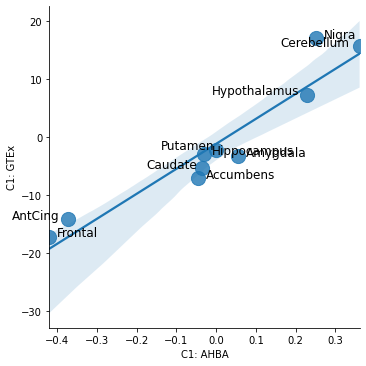

r = 0.97, p = 0.0


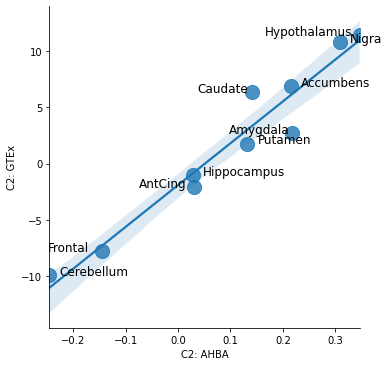

r = 0.886, p = 0.001


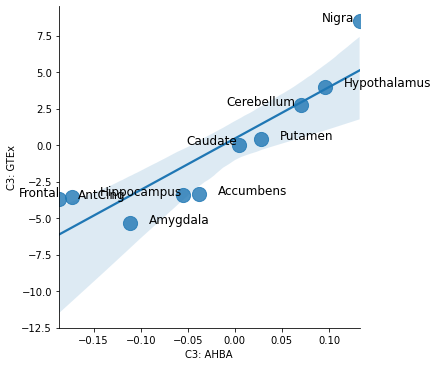

In [39]:
scale = {1:0.02,2:0.015,3:0.008}
for i in range(1,4):
    allen = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GCorr_GTexComp_ABA_C%s_data.csv'%i
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    plotr = pandas.concat([pandas.Series(allen['Component%s_Expresion'%i
                                              ].values),
                           pandas.Series(gtC['C%s'%i].values)],
                          axis=1)
    plotr.columns = ['Allen','GTEx']
    plotr.index = allen.GTeX_div.values
                      
    sns.lmplot(x='Allen',y='GTEx',data=plotr,
           scatter_kws={'marker':'o','s':200})
    r,p = stats.pearsonr(plotr.Allen.values,plotr.GTEx.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    
    for it,div in enumerate(plotr.sort_values('Allen').index):
        x = plotr.loc[div,'Allen']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = plotr.loc[div,'GTEx']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*scale[i]#.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: GTEx'%i)
    plt.show()

# Add brain divisions

In [300]:
pred.Region.value_counts()

Brain - Cortex                               255
Brain - Caudate (basal ganglia)              246
Brain - Nucleus accumbens (basal ganglia)    246
Brain - Cerebellum                           241
Brain - Cerebellar Hemisphere                215
Brain - Frontal Cortex (BA9)                 209
Brain - Putamen (basal ganglia)              205
Brain - Hypothalamus                         202
Brain - Hippocampus                          197
Brain - Anterior cingulate cortex (BA24)     176
Brain - Amygdala                             152
Brain - Substantia nigra                     139
Name: Region, dtype: int64

In [74]:
# C1

tele = ['Brain - Cortex','Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
        'Brain - Frontal Cortex (BA9)','Brain - Putamen (basal ganglia)',
        'Brain - Hippocampus','Brain - Anterior cingulate cortex (BA24)',
        'Brain - Amygdala']
dien = ['Brain - Hypothalamus']
met = ['Brain - Substantia nigra']
mes = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere']

divs = [tele, dien, met, mes]
names = ['Tele', 'Dien', 'Met', 'Mes',] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'DevOrigin'] = name

# C2
cortex = ['Brain - Cortex','Brain - Cerebellum',
         'Brain - Cerebellar Hemisphere',
         'Brain - Frontal Cortex (BA9)','Brain - Hippocampus',
         'Brain - Anterior cingulate cortex (BA24)',]
noncortex = ['Caudate (basal ganglia)',
             'Brain - Nucleus accumbens (basal ganglia)',
            'Brain - Putamen (basal ganglia)','Brain - Hypothalamus',
             'Brain - Amygdala','Brain - Substantia nigra']
divs = [cortex,noncortex]
names = ['Cortex','NonCortex'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'Cortex'] = name

# C3
assoc = ['Brain - Cortex','Brain - Frontal Cortex (BA9)',
        'Brain - Anterior cingulate cortex (BA24)']
lbf = ['Brain - Nucleus accumbens (basal ganglia)',
      'Brain - Hippocampus','Brain - Amygdala']
bg = ['Caudate (basal ganglia)','Brain - Putamen (basal ganglia)',
     ]
other = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere',
        'Brain - Hypothalamus','Brain - Substantia nigra']

divs = [assoc,lbf,bg,other]
names = ['Association','Limbic/BF','BasalGanglia','Other'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'CortType'] = name

# Look at effects across age

In [295]:
df.columns

Index(['Unnamed: 0', 'SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX', 'SMTSD',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'],
      dtype='object')

In [75]:
cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'] + bwcols
for col in cols:
    pred.loc[:,col] = df.loc[:,col].values

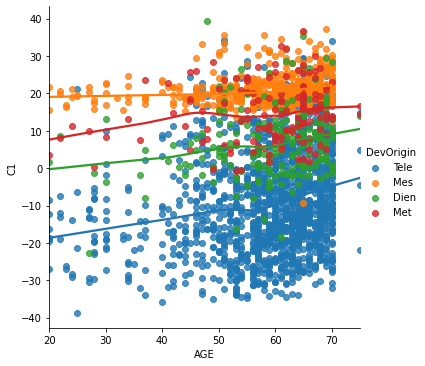

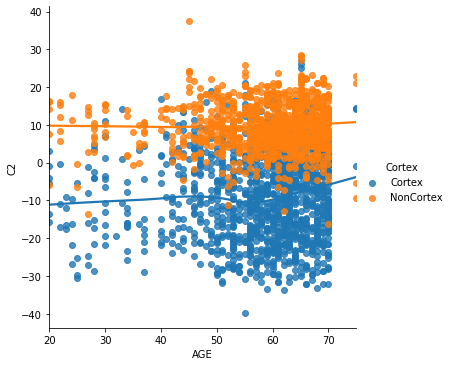

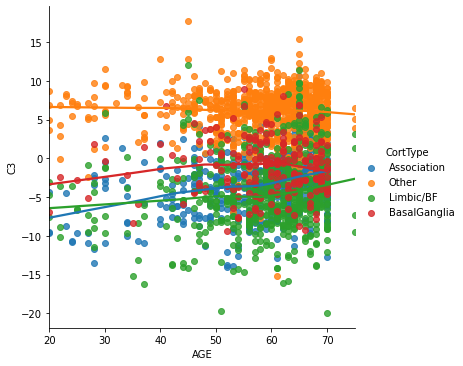

In [419]:
for c,col in {1: 'DevOrigin',2: 'Cortex', 3: 'CortType'}.items():
    sns.lmplot(x='AGE',y='C%s'%c,hue=col,lowess=True,data=pred)
    plt.show()


In [405]:
# for c,col in {1: 'DevOrigin',2: 'Cortex', 3: 'CortType'}.items():
#     sns.lmplot(x='brainweight',y='C%s'%c,hue=col,lowess=True,data=pred)
#     plt.show()


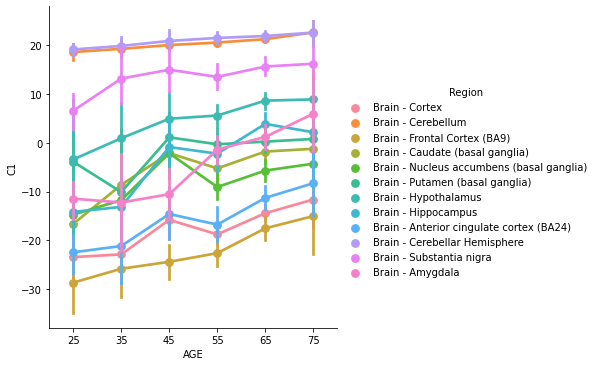

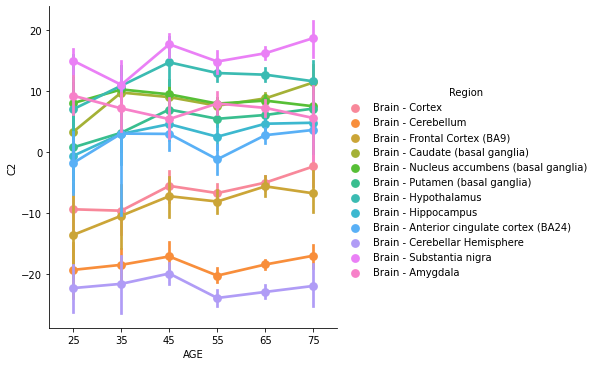

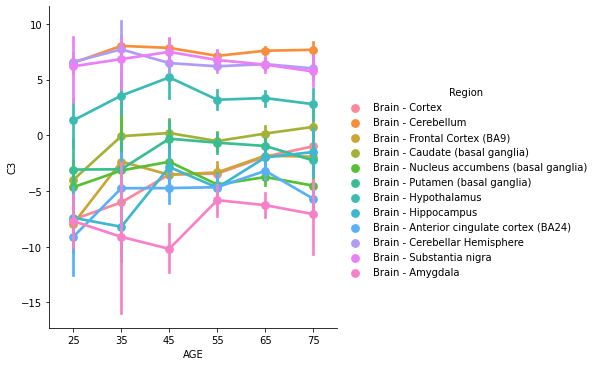

In [356]:
for i in range(1,4):
    sns.catplot(x='AGE',y='C%s'%i,hue="Region",kind='point',data=pred)
    plt.show()


# Widen dataframes for individual analysis

In [313]:
pred.Div.unique()

array(['Frontal', 'Cerebellum', 'Caudate', 'Accumbens', 'Putamen',
       'Hypothalamus', 'Hippocampus', 'AntCing', 'Nigra', 'Amygdala'],
      dtype=object)

In [76]:
gpdfs = {}
for i in range(1,4):
    gpdf = pred[['SUBJID','C%s'%i,'Div']
              ].set_index(['SUBJID'],append=True
                         ).pivot_table(index='SUBJID',
                                       columns='Div',
                                       values='C%s'%i)
    
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [359]:
print(gpdfs[1].shape)
gpdfs[1].head()

(376, 11)


Div,Accumbens,Amygdala,AntCing,Caudate,Cerebellum,Frontal,Hippocampus,Hypothalamus,Nigra,Putamen,n_valid
SUBJID,,,,,,,,,,,
GTEX-1117F,NaN,NaN,NaN,NaN,NaN,-11.488068,NaN,NaN,NaN,NaN,1.0
GTEX-111FC,NaN,NaN,NaN,NaN,17.829735,-17.099619,NaN,NaN,NaN,NaN,2.0
GTEX-1128S,NaN,NaN,NaN,NaN,22.176213,-19.392468,NaN,NaN,NaN,NaN,2.0
GTEX-117XS,NaN,NaN,NaN,NaN,18.717755,-26.021238,NaN,NaN,NaN,NaN,2.0
GTEX-1192X,-12.915961,NaN,NaN,-12.920108,20.838490,-26.264383,NaN,-4.4964,NaN,-3.240135,6.0


# Individual congruence

In [361]:
allen

,GTeX_div,Component3_Expresion,sem
Accumbens,Accumbens,-0.037912,0.017161
Amygdala,Amygdala,-0.111335,0.011702
AntCing,AntCing,-0.186796,0.009926
Caudate,Caudate,0.004346,0.005238
Cerebellum,Cerebellum,0.070770,0.001570
Frontal,Frontal,-0.173028,0.004324
Hippocampus,Hippocampus,-0.055090,0.004913
Hypothalamus,Hypothalamus,0.095435,0.005096
Nigra,Nigra,0.132499,0.004272
Putamen,Putamen,0.028209,0.006031


In [365]:
gpdfs[1].iloc[0].values

array([         nan,          nan,          nan,          nan,
                nan, -11.48806759,          nan,          nan,
                nan,          nan,   1.        ])

In [370]:
allen.loc[gpdfs[1].columns[:-1]]

,GTeX_div,Component3_Expresion,sem
Div,,,
Accumbens,Accumbens,-0.037912,0.017161
Amygdala,Amygdala,-0.111335,0.011702
AntCing,AntCing,-0.186796,0.009926
Caudate,Caudate,0.004346,0.005238
Cerebellum,Cerebellum,0.070770,0.001570
Frontal,Frontal,-0.173028,0.004324
Hippocampus,Hippocampus,-0.055090,0.004913
Hypothalamus,Hypothalamus,0.095435,0.005096
Nigra,Nigra,0.132499,0.004272


In [77]:
for c in range(1,4):
    cdf = gpdfs[c]
    allen = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GCorr_GTexComp_ABA_C%s_data.csv'%c
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    avec = allen.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(allen,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['Component%s_Expresion'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['Component%s_Expresion'%c].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

# Relationship to Brain Weight, Age, etc 

In [420]:
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = df.groupby('SUBJID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

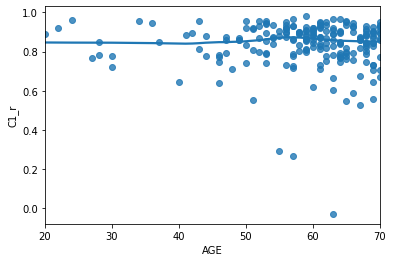

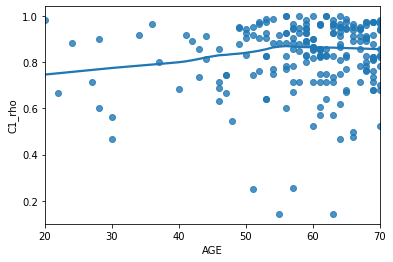

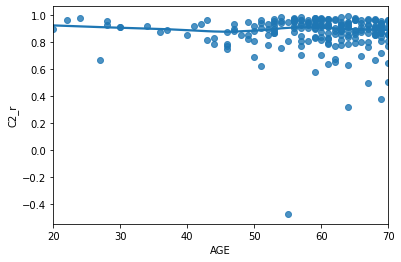

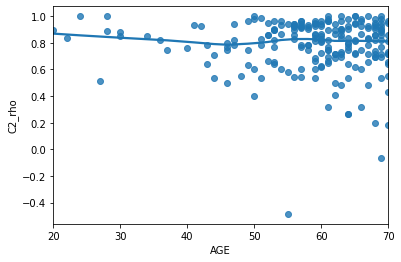

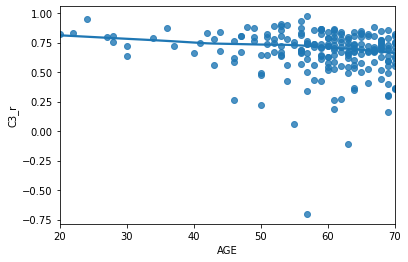

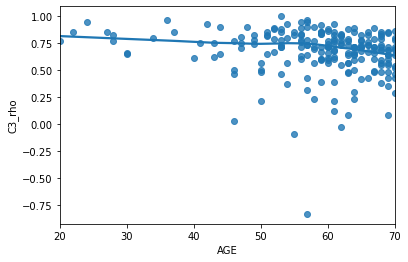

In [421]:
for c in range(1,4):
    sns.regplot(x='AGE',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,data=subsum)
    plt.show()
    sns.regplot(x='AGE',y='C%s_rho'%c,
                #hue='SEX',
                lowess=True,data=subsum)
    plt.show()

In [415]:
bwdf

,SUBJID,RIN,BATCH,GBATCH,AGE,SEX,SMTSD,SeqPC1,SeqPC2,SeqPC3,SeqPC4,SeqPC5,brainweight,weight,height,race,ethnicity,merger
GTEX-1117F_Brain - Cortex,GTEX-1117F,6.2,BP-43956,LCSET-4904,66,2,Brain - Cortex,0.730214,1.373728,-0.032430,-1.243091,-0.269011,916.0,199.0,66.00,2,0,GTEX-1117F_Brain - Cortex
GTEX-111FC_Brain - Cortex,GTEX-111FC,6.1,BP-43693,LCSET-4804,61,1,Brain - Cortex,-0.877245,0.217794,-0.722488,-2.620600,0.325254,1456.0,190.0,73.00,3,0,GTEX-111FC_Brain - Cortex
GTEX-111FC_Brain - Cerebellum,GTEX-111FC,7.1,BP-43507,LCSET-4804,61,1,Brain - Cerebellum,2.723758,-1.893202,-3.023749,-1.072355,-0.128278,1456.0,190.0,73.00,3,0,GTEX-111FC_Brain - Cerebellum
GTEX-1128S_Brain - Cortex,GTEX-1128S,6.3,BP-43783,LCSET-4805,66,2,Brain - Cortex,-0.511056,0.888433,0.002476,-1.154150,0.026175,1080.0,160.0,66.00,3,0,GTEX-1128S_Brain - Cortex
GTEX-1128S_Brain - Cerebellum,GTEX-1128S,6.3,BP-43956,LCSET-4904,66,2,Brain - Cerebellum,4.048402,-1.947349,-3.737918,1.363319,-0.354989,1080.0,160.0,66.00,3,0,GTEX-1128S_Brain - Cerebellum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZYFD_Brain - Cortex,GTEX-ZYFD,6.7,BP-44460,LCSET-4635,55,1,Brain - Cortex,-0.748883,-0.091209,-0.242834,-1.855246,-0.797409,1546.0,149.6,72.00,3,99,GTEX-ZYFD_Brain - Cortex
GTEX-ZYY3_Brain - Cerebellum,GTEX-ZYY3,5.9,BP-44261,LCSET-4796,67,2,Brain - Cerebellum,1.208017,-1.932781,-2.645948,-0.880296,-0.242357,925.0,103.4,58.67,3,99,GTEX-ZYY3_Brain - Cerebellum
GTEX-ZYY3_Brain - Cortex,GTEX-ZYY3,6.8,BP-43956,LCSET-5174,67,2,Brain - Cortex,2.027194,0.410584,-1.541312,-2.250602,0.414408,925.0,103.4,58.67,3,99,GTEX-ZYY3_Brain - Cortex
GTEX-ZZPT_Brain - Cerebellum,GTEX-ZZPT,6.8,BP-44460,LCSET-4767,53,1,Brain - Cerebellum,4.699732,0.038042,-2.654679,-0.292978,0.182343,1170.0,146.0,70.00,3,99,GTEX-ZZPT_Brain - Cerebellum


r=-0.031, p=0.6515


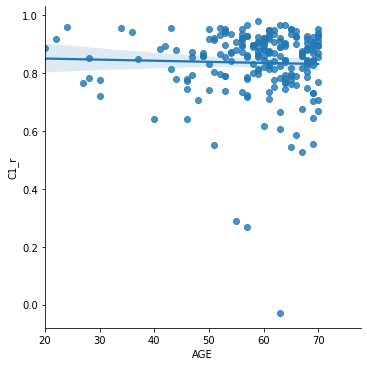

r=0.118, p=0.0855


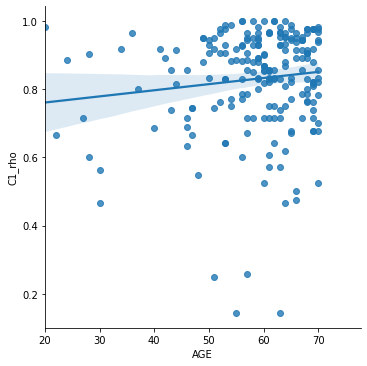

r=-0.049, p=0.4803


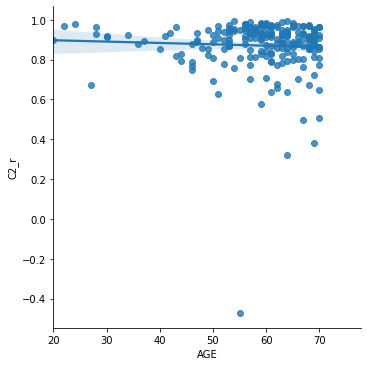

r=-0.075, p=0.2745


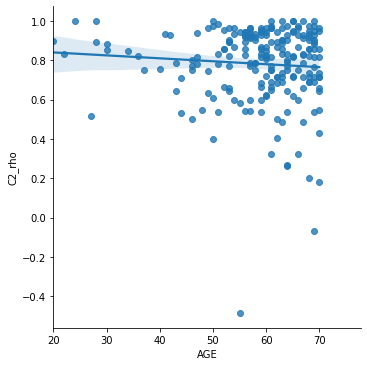

r=-0.175, p=0.0108


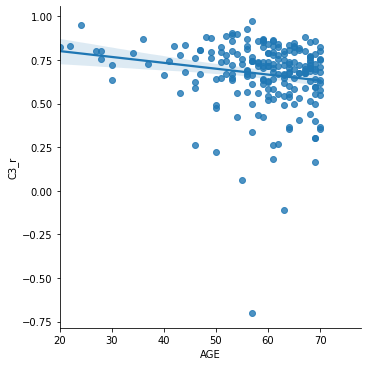

r=-0.168, p=0.0141


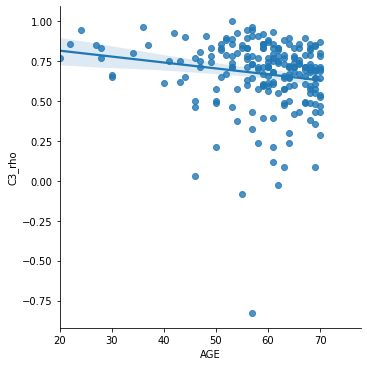

In [422]:
for c in range(1,4):
    sns.lmplot(x='AGE',y='C%s_r'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'AGE']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.AGE.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()
    sns.lmplot(x='AGE',y='C%s_rho'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'AGE']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
                      plotr.AGE.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()

In [423]:
subsum.to_csv('/Users/jacobv/Science/PLS_GXP/GTEx_IndivCongruence.csv')

r=0.051, p=0.4594


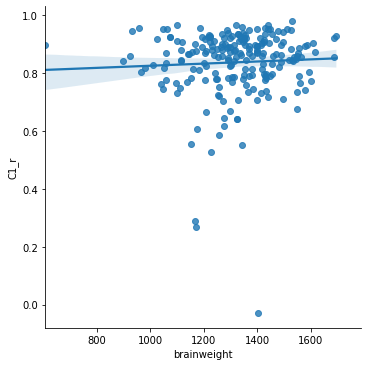

r=0.027, p=0.701


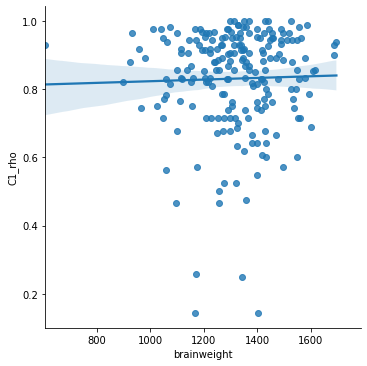

r=0.139, p=0.0439


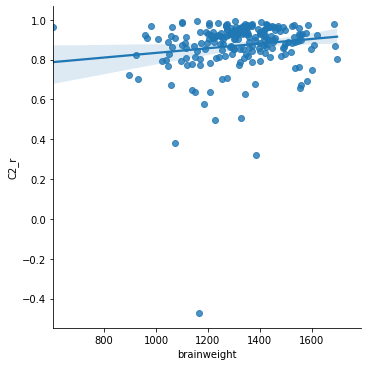

r=0.142, p=0.04


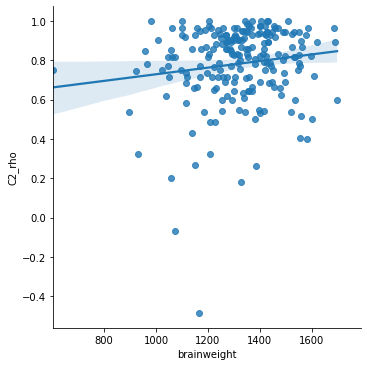

r=0.145, p=0.0349


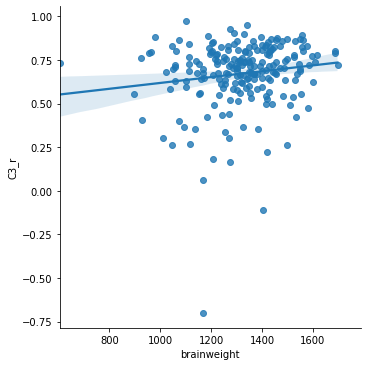

r=0.15, p=0.029


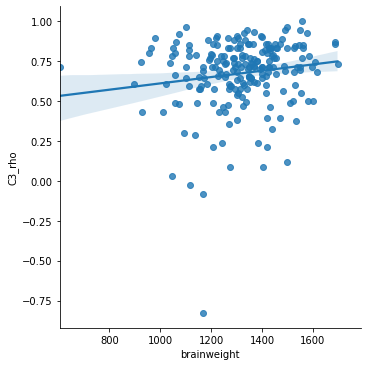

In [411]:
for c in range(1,4):
    sns.lmplot(x='brainweight',y='C%s_r'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'brainweight']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.brainweight.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()
    sns.lmplot(x='brainweight',y='C%s_rho'%c,
                #hue='SEX',
                #lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_rho'%c,'brainweight']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_rho'%c].values,
                      plotr.brainweight.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    plt.show()

# Individual PLS scores

In [427]:
matched_comps.head()

,gene_symbol,gene_name,C1_expr,C2_expr,C3_expr
0,A1BG,alpha-1-B glycoprotein,0.001517,0.006065,-0.020001
1,A1BG-AS1,NaN,-0.006685,-0.006733,-0.002762
2,A2M,alpha-2-macroglobulin,0.005135,0.007225,0.002345
3,A2ML1,alpha-2-macroglobulin-like 1,-0.009261,-0.004295,-0.010945
5,A4GALT,"alpha 1,4-galactosyltransferase",-0.003285,0.007128,0.004642


In [435]:
len(np.dot(exp[exp.columns[1:-1]].T,matched_comps.C1_expr.values))

2483

In [438]:
len(np.dot(exp[exp.columns[1:-1]].T,pos))

2483

In [444]:
pos.shape

AttributeError: 'int' object has no attribute 'shape'

In [79]:
from copy import copy
for c in range(1,4):
    df.loc[:,'FullC%sScr'%c] = np.dot(exp[exp.columns[:-1]
                                         ].T,matched_comps['C%s_expr'%c
                                                          ].values
                                     )
    df.loc[:,'AbsC%sScr'%c] = np.dot(exp[exp.columns[:-1]
                                         ].T,abs(matched_comps['C%s_expr'%c
                                                          ].values)
                                     )
    vec = copy(matched_comps.loc[:,'C%s_expr'%c].values)
    vec[vec<0] = 0
    df.loc[:,'PosC%s'%c] = np.dot(exp[exp.columns[:-1]].T,vec)
    vec = copy(matched_comps.loc[:,'C%s_expr'%c].values)
    vec[vec>0] = 0
    df.loc[:,'Neg%s'%c] = np.dot(exp[exp.columns[:-1]].T,abs(vec))

In [453]:
df.columns[-12:]

Index(['FullC1Scr', 'AbsC1Scr', 'PosC1', 'Neg1', 'FullC2Scr', 'AbsC2Scr',
       'PosC2', 'Neg2', 'FullC3Scr', 'AbsC3Scr', 'PosC3', 'Neg3'],
      dtype='object')

In [81]:
res = pandas.DataFrame()
count = 0
for reg in df.SMTSD.unique():
    sdf = df[df.SMTSD==reg].dropna()
    for dv in ['AGE','brainweight']:
        for var in df.columns[-12:]:
            r,p = stats.pearsonr(sdf[dv].values,sdf[var].values)
            res.loc[count,'i'] = 0
            res.loc[count,'region'] = reg
            res.loc[count,'dv'] = dv
            res.loc[count,'cscr'] = var
            res.loc[count,'r'] = r
            res.loc[count,'p'] = p
            res.loc[count,'n'] = len(sdf)
            count+=1
#res[res..loc[:],multipletests

In [82]:
res[res.dv=='AGE'].sort_values('p').head(10)

,i,region,dv,cscr,r,p,n
8,0.0,Brain - Cortex,AGE,FullC3Scr,0.354577,6.570517e-09,253.0
56,0.0,Brain - Frontal Cortex (BA9),AGE,FullC3Scr,0.294909,1.684485e-05,206.0
176,0.0,Brain - Hippocampus,AGE,FullC3Scr,0.306335,2.886019e-05,180.0
168,0.0,Brain - Hippocampus,AGE,FullC1Scr,0.297560,4.978303e-05,180.0
2,0.0,Brain - Cortex,AGE,PosC1,0.221839,3.772732e-04,253.0
10,0.0,Brain - Cortex,AGE,PosC3,0.193628,1.975236e-03,253.0
171,0.0,Brain - Hippocampus,AGE,Neg1,-0.222641,2.664342e-03,180.0
0,0.0,Brain - Cortex,AGE,FullC1Scr,0.183472,3.403190e-03,253.0
50,0.0,Brain - Frontal Cortex (BA9),AGE,PosC1,0.191590,5.803235e-03,206.0
48,0.0,Brain - Frontal Cortex (BA9),AGE,FullC1Scr,0.190857,5.996835e-03,206.0


<AxesSubplot:xlabel='AGE', ylabel='FullC1Scr'>

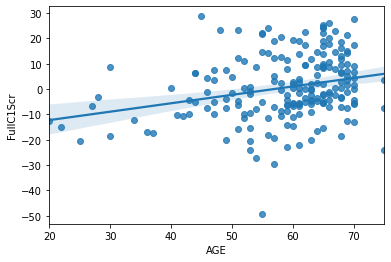

In [83]:
sns.regplot(x='AGE',y='FullC1Scr',data=df[df.SMTSD=='Brain - Hippocampus'])

<AxesSubplot:xlabel='AGE', ylabel='FullC3Scr'>

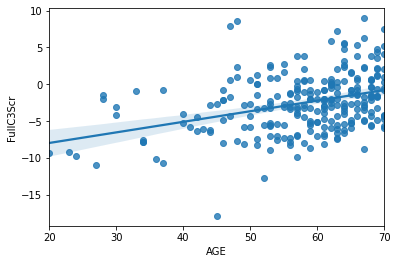

In [84]:
sns.regplot(x='AGE',y='FullC3Scr',data=df[df.SMTSD=='Brain - Cortex'])

In [464]:
res[res.dv=='brainweight'].sort_values('p').head(10)

,i,region,dv,cscr,r,p,n
68,0.0,Brain - Frontal Cortex (BA9),brainweight,FullC3Scr,-0.301900,0.000010,206.0
64,0.0,Brain - Frontal Cortex (BA9),brainweight,FullC2Scr,-0.267330,0.000103,206.0
44,0.0,Brain - Cerebellum,brainweight,FullC3Scr,-0.229611,0.000335,240.0
20,0.0,Brain - Cortex,brainweight,FullC3Scr,-0.206553,0.000950,253.0
60,0.0,Brain - Frontal Cortex (BA9),brainweight,FullC1Scr,-0.224084,0.001204,206.0
84,0.0,Brain - Caudate (basal ganglia),brainweight,FullC1Scr,-0.182333,0.004776,238.0
16,0.0,Brain - Cortex,brainweight,FullC2Scr,-0.169794,0.006788,253.0
12,0.0,Brain - Cortex,brainweight,FullC1Scr,-0.167036,0.007757,253.0
92,0.0,Brain - Caudate (basal ganglia),brainweight,FullC3Scr,-0.169171,0.008923,238.0
180,0.0,Brain - Hippocampus,brainweight,FullC1Scr,-0.185919,0.012461,180.0


In [488]:
df.columns

Index(['Unnamed: 0', 'SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX', 'SMTSD',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5', 'merger',
       'brainweight', 'weight', 'height', 'race', 'ethnicity', 'FullC1Scr',
       'AbsC1Scr', 'PosC1', 'Neg1', 'FullC2Scr', 'AbsC2Scr', 'PosC2', 'Neg2',
       'FullC3Scr', 'AbsC3Scr', 'PosC3', 'Neg3'],
      dtype='object')

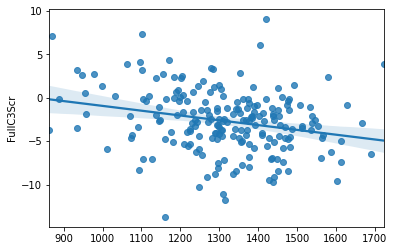

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FullC3Scr   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     6.320
Date:                Fri, 19 Mar 2021   Prob (F-statistic):           1.04e-06
Time:                        15:28:38   Log-Likelihood:                -536.59
No. Observations:                 206   AIC:                             1089.
Df Residuals:                     198   BIC:                             1116.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0778      2.659      0.029      0.977      -5.165       5.321
brainweight    -0.0051      0.001     -3.520      0.001      -0.008      -0.002
AGE             0.0704      0.026      2.744      0.007       0.020       0.121
SeqPC1          0.2007      0.078      2.588      0.010       0.048       0.354
SeqPC2          0.0097      0.150      0.064      0.949      -0.287       0.306
SeqPC3          0.2281      0.165      1.386      0.167      -0.096       0.553
SeqPC4          0.2860      0.173      1.656      0.099      -0.055       0.627
SeqPC5         -0.0482      0.144     -0.334      0.738      -0.332       0.236
==============================================================================
Omnibus:                        5.168   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                7.395
Skew:                          -0.018   Prob(JB):                       0.0248
Kurtosis:                       3.927   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [489]:
sns.regplot(x='brainweight',y='FullC3Scr',x_partial='AGE',
            data=df[df.SMTSD=='Brain - Frontal Cortex (BA9)'])
plt.show()
smf.ols('FullC3Scr ~ brainweight + AGE + SeqPC1 + SeqPC2 + SeqPC3 + SeqPC4 + SeqPC5',
        df[df.SMTSD=='Brain - Frontal Cortex (BA9)']).fit().summary()

#### Repeat after tissue specific covariation

In [506]:
from glob import glob

In [507]:
tdfs = sorted(glob('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_*.txt'))
tdfs

['/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Amygdala.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Anterior_cingulate_cortex_BA24.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Caudate_basal_ganglia.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Cerebellar_Hemisphere.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Cerebellum.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Cortex.v8.covariates.txt',
 '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_Analysis_v8_eQTL_covariates/Brain_Frontal_Cortex_BA9.v8.covariates.txt',
 '/U

In [508]:
df.SMTSD.value_counts()

Brain - Cortex                               255
Brain - Caudate (basal ganglia)              246
Brain - Nucleus accumbens (basal ganglia)    246
Brain - Cerebellum                           241
Brain - Cerebellar Hemisphere                215
Brain - Frontal Cortex (BA9)                 209
Brain - Putamen (basal ganglia)              205
Brain - Hypothalamus                         202
Brain - Hippocampus                          197
Brain - Anterior cingulate cortex (BA24)     176
Brain - Amygdala                             152
Brain - Substantia nigra                     139
Name: SMTSD, dtype: int64

In [510]:
from difflib import get_close_matches

In [512]:
for ss in tdfs:
    nm = os.path.split(ss)[1].split('.')[0].replace('Brain_','Brain - '
                                                   ).replace('_',' ')
    match = get_close_matches(nm,df.SMTSD.unique())
    if len(match)<0:
    print(nm,match[0])
    #tdf = pandas.read_csv(ss,sep='\t',index_col=0)
    

Brain - Amygdala Brain - Amygdala
Brain - Anterior cingulate cortex BA24 Brain - Anterior cingulate cortex (BA24)
Brain - Caudate basal ganglia Brain - Caudate (basal ganglia)
Brain - Cerebellar Hemisphere Brain - Cerebellar Hemisphere
Brain - Cerebellum Brain - Cerebellum
Brain - Cortex Brain - Cortex
Brain - Frontal Cortex BA9 Brain - Frontal Cortex (BA9)
Brain - Hippocampus Brain - Hippocampus
Brain - Hypothalamus Brain - Hypothalamus
Brain - Nucleus accumbens basal ganglia Brain - Nucleus accumbens (basal ganglia)
Brain - Putamen basal ganglia Brain - Putamen (basal ganglia)


IndexError: list index out of range

In [504]:
df.head()

,Unnamed: 0,SUBJID,RIN,BATCH,GBATCH,AGE,SEX,SMTSD,SeqPC1,SeqPC2,...,PosC1,Neg1,FullC2Scr,AbsC2Scr,PosC2,Neg2,FullC3Scr,AbsC3Scr,PosC3,Neg3
0,GTEX-1117F-3226-SM-5N9CT,GTEX-1117F,6.2,BP-43956,LCSET-4904,66,2,Brain - Cortex,0.730214,1.373728,...,-6.046802,5.441266,-5.630618,-1.591363,-3.610990,2.019628,-2.186523,-3.240344,-2.713434,-0.526911
1,GTEX-111FC-3126-SM-5GZZ2,GTEX-111FC,6.1,BP-43693,LCSET-4804,61,1,Brain - Cortex,-0.877245,0.217794,...,11.421029,28.520648,-6.381249,38.041508,15.830129,22.211379,-1.646139,37.199506,17.776684,19.422823
2,GTEX-111FC-3326-SM-5GZYV,GTEX-111FC,7.1,BP-43507,LCSET-4804,61,1,Brain - Cerebellum,2.723758,-1.893202,...,33.600473,15.770738,-14.959605,54.060833,19.550614,34.510219,7.749785,53.131166,30.440475,22.690691
3,GTEX-1128S-2726-SM-5H12C,GTEX-1128S,6.3,BP-43783,LCSET-4805,66,2,Brain - Cortex,-0.511056,0.888433,...,-1.855060,17.537407,-9.699070,12.641920,1.471425,11.170495,-1.102744,12.428704,5.662980,6.765724
4,GTEX-1128S-2826-SM-5N9DI,GTEX-1128S,6.3,BP-43956,LCSET-4904,66,2,Brain - Cerebellum,4.048402,-1.947349,...,22.672582,0.496369,-21.489573,27.316072,2.913250,24.402823,8.793784,26.310600,17.552192,8.758408


In [503]:
jnk

,GTEX-11NUK,GTEX-11ONC,GTEX-11PRG,GTEX-11TTK,GTEX-11ZU8,GTEX-11ZVC,GTEX-12WSA,GTEX-12WSD,GTEX-12WSF,GTEX-12WSH,...,GTEX-WZTO,GTEX-X4EP,GTEX-X4XX,GTEX-X585,GTEX-XLM4,GTEX-Y8DK,GTEX-YFC4,GTEX-ZAB4,GTEX-ZAK1,GTEX-ZVZQ
ID,,,,,,,,,,,,,,,,,,,,,
PC1,0.013900,0.014500,-0.110600,0.016100,0.014600,0.014600,0.015000,-0.104900,0.015300,0.014000,...,0.010500,0.012800,0.008900,-0.107300,0.014900,0.014800,0.014700,0.013800,0.015900,0.015800
PC2,-0.000600,-0.009800,-0.015500,-0.000900,-0.000900,-0.003500,-0.000400,-0.019000,-0.006200,-0.002100,...,0.000400,-0.006500,0.002100,-0.020100,-0.006000,-0.007400,-0.008400,-0.002100,-0.003000,-0.003600
PC3,0.006000,0.015500,-0.003800,0.028700,0.041700,0.015000,0.035400,0.000300,0.020700,-0.005800,...,-0.057600,0.017300,-0.137500,0.005100,0.013000,0.006000,0.007800,0.000700,0.005300,0.025800
PC4,0.027500,0.005400,-0.004500,0.009100,0.030300,0.029200,0.027900,0.006500,0.001200,0.001300,...,0.013500,0.023400,0.005300,0.008300,0.016600,0.005500,0.010300,0.008500,0.002600,-0.009300
PC5,-0.020000,0.025800,-0.010200,-0.113600,-0.144500,-0.105800,-0.115200,-0.003400,0.034800,0.018400,...,-0.015200,0.001000,-0.005700,-0.004700,0.050400,0.009600,0.041700,-0.038800,0.026500,0.010300
InferredCov1,0.058590,-0.023123,0.053242,-0.020250,0.021051,-0.058648,-0.068942,0.011135,-0.015742,0.029261,...,0.084515,-0.122750,-0.073016,-0.050829,0.015935,-0.039076,0.019437,0.010958,-0.020435,0.026732
InferredCov2,-0.012409,-0.010176,0.006241,-0.082099,-0.196663,-0.100201,-0.058055,0.015539,0.023761,-0.152073,...,0.140427,0.029018,0.075048,0.047894,0.086416,-0.009745,0.073874,0.083474,-0.039608,0.024285
InferredCov3,-0.049089,0.020211,0.002382,-0.022835,-0.089543,-0.078139,0.012233,0.035481,0.039698,-0.023228,...,0.000872,-0.014196,0.043342,0.006392,-0.008873,0.068669,-0.023969,0.013057,-0.018886,-0.069868
InferredCov4,0.013162,0.004551,-0.031882,0.064560,-0.006344,0.037838,-0.019983,0.046450,-0.037121,-0.114375,...,-0.042863,0.063057,-0.080873,-0.090469,-0.024213,-0.037283,-0.008673,-0.103001,0.026896,0.027366


<AxesSubplot:xlabel='ID', ylabel='ID'>

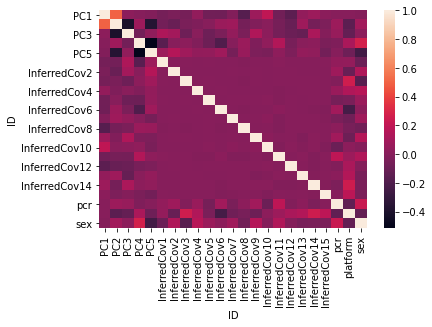

In [498]:
jnk = pandas.DataFrame(np.corrcoef(jnk.values),index=jnk.index,
                      columns=jnk.index)
sns.heatmap(jnk)

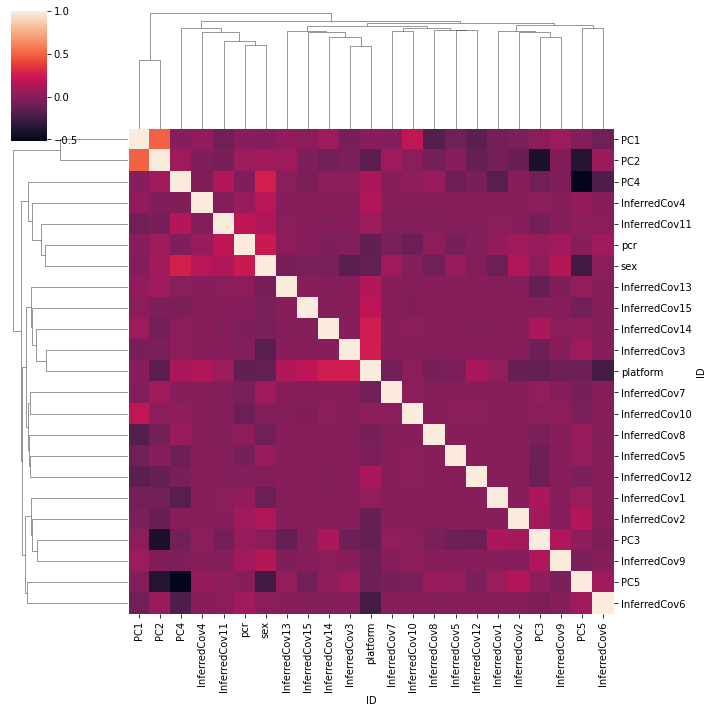

In [499]:
sns.clustermap(jnk)

In [ ]:
pandas.read_hdf()

In [473]:
#from scipy.io import loadmat
#mmat = loadmat('/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_P14.mat')
#mmat = pandas.read_hdf('/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_P14.mat')
import h5py
import numpy as np
filepath = '/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_P14.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [474]:
arrays.keys()

dict_keys(['#refs#', '#subsystem#', 'coOrds', 'geneIDs', 'geneInfo', 'voxGeneMat', 'voxLabelTable'])

In [477]:
arrays['coOrds'].shape

(3, 24213)

In [480]:
arrays['geneIDs'].shape

(1, 2069)

In [483]:
arrays['geneInfo']

array([[3707764736,          2,          1,          1,          6,
                 6]], dtype=uint32)

In [484]:
arrays['voxGeneMat'].shape

(2069, 24213)

In [515]:
hlog = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HomoloGene ID	Common Organism Name	NCBI Taxon ID	S',
                      sep='\t')
hlog['Common Organism Name'].value_counts()

mouse, laboratory       20891
zebrafish               20889
rat                     20606
human                   19124
cattle                  18776
chimpanzee              18728
frog, western clawed    18446
dog, domestic           17951
macaque, rhesus         16816
chicken                 14593
Name: Common Organism Name, dtype: int64